<a href="https://colab.research.google.com/github/rliu7926/weinstein-ligo-research/blob/main/4.3%20Merger%20Rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install -q 'PyCBC==1.15.3' 'lalsuite==6.66'
! pip install astropy
! pip install sympy

from astropy.cosmology import FlatLambdaCDM, Planck18, z_at_value
import astropy
import numpy as np
from numpy import diff 
import pylab
import math

import astropy.units as u
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from numpy import trapz

from pycbc import waveform
from pycbc.waveform import get_td_waveform, get_fd_waveform

import pycbc
import pycbc.noise
import pycbc.psd

from random import randint
from pycbc.filter import matched_filter
from pycbc.psd import interpolate, inverse_spectrum_truncation

import pandas as pd
from pycbc.types import TimeSeries

import seaborn as sns
import time

     |████████████████████████████████| 3.1MB 25.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 28.5MB 110kB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
     |████████████████████████████████| 1.0MB 33.5MB/s 
     |████████████████████████████████| 81kB 8.0MB/s 
     |████████████████████████████████| 1.6MB 46.8MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
     |████████████████████████████████| 3.2MB 47.8MB/s 


In [ ]:
## Merger rate density as a function of redshift (comoving volume)

z = np.arange(0, 100, 0.01)
rbbh_ne_1, rbbh_ne_2, rbbh_ne_3, rbbh_1, rbbh_2, rbbh_3 = ([0] * len(z) for i in range(6))

for i in range(len(z)):
  
  # Non-evolving model 

  rbbh_ne_1[i] = 23.9 # POWER LAW + PEAK mass distribution; m1 >= m2 = 3
  rbbh_ne_2[i] = 33 # TRUNCATED model; m1 >= m2 = 3
  rbbh_ne_3[i] = 52 # POWER LAW + PEAK model; m1 >= 3, m2 >= 2

  # Power law model 

  rbbh_1[i] = 19.3 * (1+z[i])**1.3 # POWER LAW + PEAK model
  rbbh_2[i] = 19.3 * (1+z[i])**1.8 ## BROKEN POWER LAW model

  # Tapering power law model 

  rbbh_3[i] = 19.3 * (1+z[i])**2.7 / (1 + ((1+z[i])/2.9)**5.6)
 

In [ ]:
## Merger rate as a function of redshift and time only 

def ProbDistA(z, c, p): # Simple power law
  return Planck18.differential_comoving_volume(z).value / 10**12 * 4*np.pi * (1+z)**(p-1) * c

def ProbDistB(z, c, p, a, b): # Power law that tapers off (based on SFR)
  return Planck18.differential_comoving_volume(z).value / 10**12 * 4*np.pi * (1+z)**(p-1) / (1 + ((1+z)/a)**b) * c

zvals = np.arange(0, 20, 0.01)
rbbhne1, rbbhne2, rbbhne3, rbbh1, rbbh2, rbbh3 = ([0] * len(zvals) for i in range(6))

for i in range(len(zvals)):
  rbbhne1[i] = ProbDistA(zvals[i], 23.9, 0)
  rbbhne2[i] = ProbDistA(zvals[i], 33, 0)
  rbbhne3[i] = ProbDistA(zvals[i], 52, 0)

  rbbh1[i] = ProbDistA(zvals[i], 19.3, 1.3)
  rbbh2[i] = ProbDistA(zvals[i], 19.3, 1.8)
  rbbh3[i] = ProbDistB(zvals[i], 19.3, 2.7, 2.9, 5.6)


Text(0, 0.5, 'Comoving Volume ($Gpc^3$)')

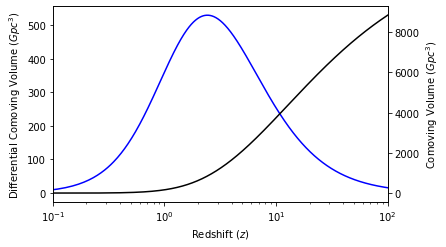

In [ ]:
## Comoving volume as a function of redshift 

comoving_volume, differential_comoving_volume = ([0] * len(z) for i in range(2))

for i in range(len(z)):
  comoving_volume[i] = Planck18.comoving_volume(z[i]).value / 10**9
  differential_comoving_volume[i] = Planck18.differential_comoving_volume(z[i]).value / 10**9 * 4*np.pi

fig = plt.figure(figsize=(6, 3.6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()

ax1.plot(z, differential_comoving_volume, color="blue")
ax1.set_xlabel("Redshift ($z$)")
ax1.set_ylabel("Differential Comoving Volume ($Gpc^3$)")
ax1.set_xscale('log')
ax1.set_xlim(0.1, 100)

ax2.plot(z, comoving_volume, color="black")
ax2.set_ylabel("Comoving Volume ($Gpc^3$)")

In [ ]:
## Total number of mergers within a particular redshift 

rbbh1_tot, rbbh2_tot, rbbh3_tot, rbbhne1_tot, rbbhne2_tot, rbbhne3_tot, zdist = ([0] * len(zvals) for i in range(7))

for i in range(len(zvals)):
  zdist[i] = Planck18.comoving_distance(zvals[i]).value

for i in range(len(zvals)):
  rbbh1_tot[i] = trapz(y=np.array(rbbh1)[0:i,], x=np.array(zdist)[0:i,])
  rbbh2_tot[i] = trapz(y=np.array(rbbh1)[0:i,], x=np.array(zdist)[0:i,])
  rbbh3_tot[i] = trapz(y=np.array(rbbh1)[0:i,], x=np.array(zdist)[0:i,])

  rbbhne1_tot[i] = trapz(y=np.array(rbbhne1)[0:i,], x=np.array(zdist)[0:i,])
  rbbhne2_tot[i] = trapz(y=np.array(rbbhne2)[0:i,], x=np.array(zdist)[0:i,])
  rbbhne3_tot[i] = trapz(y=np.array(rbbhne3)[0:i,], x=np.array(zdist)[0:i,])


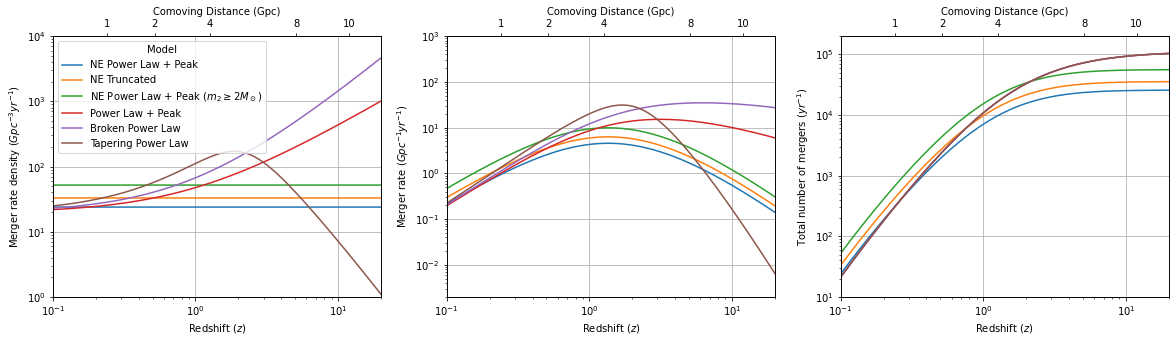

In [ ]:
fig = plt.figure(figsize=(20, 4.8))
ax1 = fig.add_subplot(131)
ax2 = ax1.twiny()

models = [rbbh_ne_1, rbbh_ne_2, rbbh_ne_3, rbbh_1, rbbh_2, rbbh_3]
for i in range(len(models)):
  ax1.loglog(z, models[i])
ax1.set_xlabel("Redshift ($z$)")
ax1.set_ylabel("Merger rate density ($Gpc^{-3} yr^{-1}$)")
ax1.legend(labels=["NE Power Law + Peak", "NE Truncated", "NE Power Law + Peak ($m_2 \geq 2 M_\odot$)", "Power Law + Peak", "Broken Power Law", "Tapering Power Law"], title="Model")

distticks = [1, 2, 4, 8, 10]
zticks = [0] * len(distticks)
for i in range(len(distticks)):
  zticks[i] = z_at_value(Planck18.comoving_distance, distticks[i] * u.Gpc)

ax2.set_xscale('log')
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(zticks)
ax2.set_xticklabels(distticks)
ax2.set_xlabel("Comoving Distance (Gpc)")
ax2.tick_params(axis="x", top=False, which="minor")

ax3 = fig.add_subplot(133)
ax4 = ax3.twiny()

models_tot = [rbbhne1_tot, rbbhne2_tot, rbbhne3_tot, rbbh1_tot, rbbh2_tot, rbbh3_tot]
for i in range(len(models_tot)):
  ax3.loglog(zvals, models_tot[i])
ax3.set_xlabel("Redshift ($z$)")
ax3.set_ylabel("Total number of mergers ($yr^{-1}$)")

ax4.set_xscale('log')
ax4.set_xlim(ax1.get_xlim())
ax4.set_xticks(zticks)
ax4.set_xticklabels(distticks)
ax4.set_xlabel("Comoving Distance (Gpc)")
ax4.tick_params(axis="x", top=False, which="minor")

ax5 = fig.add_subplot(132)
ax6 = ax5.twiny()

models_dist = [rbbhne1, rbbhne2, rbbhne3, rbbh1, rbbh2, rbbh3]
for i in range(len(models_dist)):
  ax5.loglog(zvals[0:len(models_dist[i])], models_dist[i])
ax5.set_xlabel("Redshift ($z$)")
ax5.set_ylabel("Merger rate ($Gpc^{-1} yr^{-1}$)")

ax6.set_xscale('log')
ax6.set_xlim(ax1.get_xlim())
ax6.set_xticks(zticks)
ax6.set_xticklabels(distticks)
ax6.set_xlabel("Comoving Distance (Gpc)")
ax6.tick_params(axis="x", top=False, which="minor")

ax1.grid()
ax1.set_xlim(0.1, 20)
ax2.set_xlim(0.1, 20)
ax1.set_ylim(1, 10**4)

ax3.grid()
ax3.set_xlim(0.1, 20)
ax4.set_xlim(0.1, 20)
ax3.set_ylim(10, 2*10**5)

ax5.grid()
ax5.set_xlim(0.1, 20)
ax6.set_xlim(0.1, 20)
ax5.set_ylim(2*10**-3, 1000)

plt.subplots_adjust(wspace=0.2)
plt.show()